In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# ====== Load dataset (Cora only) ======
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

# ====== GCN Model ======
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # raw logits

# ====== Training & Evaluation ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 64, dataset.num_classes, dropout=0.5).to(device)
data = data.to(device)

# Label smoothing via CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

# ====== Run training ======
best_val_acc = 0
patience, patience_counter = 5, 0

print("\n==== Training on Cora (with label smoothing) ====")
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 1 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Train: {train_acc:.3f}, Val: {val_acc:.3f}, Test: {test_acc:.3f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nBest Val Acc: {best_val_acc:.3f}, Test Acc: {best_test_acc:.3f}")



==== Training on Cora (with label smoothing) ====
Epoch 001, Loss: 1.9525, Train: 0.914, Val: 0.680, Test: 0.716
Epoch 002, Loss: 1.7314, Train: 0.964, Val: 0.742, Test: 0.792
Epoch 003, Loss: 1.4754, Train: 0.964, Val: 0.770, Test: 0.800
Epoch 004, Loss: 1.2320, Train: 0.979, Val: 0.764, Test: 0.796
Epoch 005, Loss: 0.9920, Train: 0.979, Val: 0.780, Test: 0.797
Epoch 006, Loss: 0.8496, Train: 0.986, Val: 0.772, Test: 0.802
Epoch 007, Loss: 0.7194, Train: 0.986, Val: 0.788, Test: 0.802
Epoch 008, Loss: 0.6391, Train: 0.993, Val: 0.780, Test: 0.805
Epoch 009, Loss: 0.6017, Train: 1.000, Val: 0.780, Test: 0.812
Epoch 010, Loss: 0.5702, Train: 1.000, Val: 0.788, Test: 0.817
Epoch 011, Loss: 0.5756, Train: 1.000, Val: 0.794, Test: 0.812
Epoch 012, Loss: 0.5810, Train: 1.000, Val: 0.800, Test: 0.813
Epoch 013, Loss: 0.5690, Train: 1.000, Val: 0.792, Test: 0.812
Epoch 014, Loss: 0.5842, Train: 1.000, Val: 0.778, Test: 0.811
Epoch 015, Loss: 0.5788, Train: 1.000, Val: 0.762, Test: 0.802
Epoc

          Name    Mean       Std
0     Baseline  0.8036  0.006375
1  HighDropout  0.8082  0.003970
2  LabelSmooth  0.8036  0.007144
3    StrongReg  0.8186  0.005389


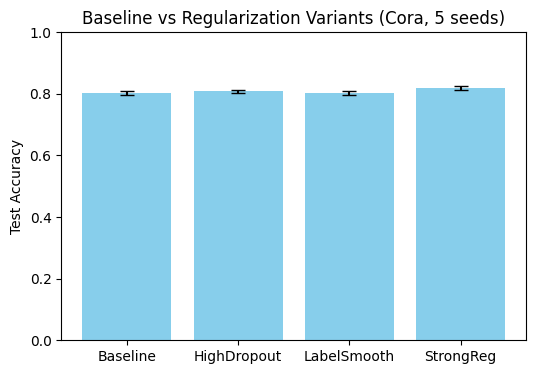

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert summary to DataFrame
df = pd.DataFrame(summary, columns=["Name", "Mean", "Std"])
print(df)

# Bar plot with error bars
plt.figure(figsize=(6,4))
plt.bar(df["Name"], df["Mean"], yerr=df["Std"], capsize=5, color="skyblue")
plt.ylabel("Test Accuracy")
plt.title("Baseline vs Regularization Variants (Cora, 5 seeds)")
plt.ylim(0,1)
plt.show()


Running grid: 12 configs × 3 seeds = 36 runs
cfg dropout=0.5 lab_smooth=0.1 wd=0.0005 hid=64 -> mean test 0.8073 ± 0.0058
cfg dropout=0.5 lab_smooth=0.1 wd=0.005 hid=64 -> mean test 0.8207 ± 0.0034
cfg dropout=0.5 lab_smooth=0.2 wd=0.0005 hid=64 -> mean test 0.8107 ± 0.0021
cfg dropout=0.5 lab_smooth=0.2 wd=0.005 hid=64 -> mean test 0.8200 ± 0.0024
cfg dropout=0.7 lab_smooth=0.1 wd=0.0005 hid=64 -> mean test 0.8147 ± 0.0062
cfg dropout=0.7 lab_smooth=0.1 wd=0.005 hid=64 -> mean test 0.8193 ± 0.0012
cfg dropout=0.7 lab_smooth=0.2 wd=0.0005 hid=64 -> mean test 0.8133 ± 0.0033
cfg dropout=0.7 lab_smooth=0.2 wd=0.005 hid=64 -> mean test 0.8177 ± 0.0042
cfg dropout=0.9 lab_smooth=0.1 wd=0.0005 hid=64 -> mean test 0.8200 ± 0.0014
cfg dropout=0.9 lab_smooth=0.1 wd=0.005 hid=64 -> mean test 0.8210 ± 0.0073
cfg dropout=0.9 lab_smooth=0.2 wd=0.0005 hid=64 -> mean test 0.8177 ± 0.0037
cfg dropout=0.9 lab_smooth=0.2 wd=0.005 hid=64 -> mean test 0.8197 ± 0.0061

Saved detailed runs to reg_sweep_cor

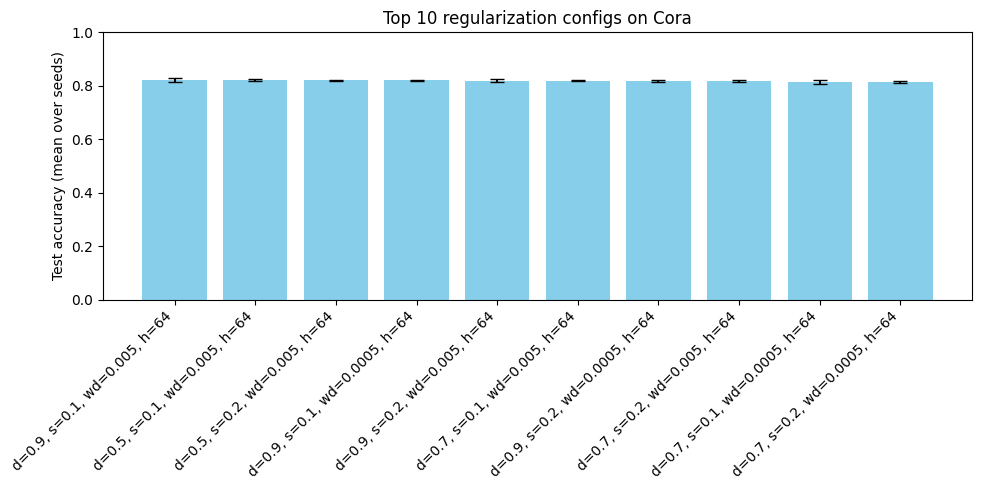

Saved plot to reg_sweep_top10.png


In [5]:
# reg_sweep_cora.py
import os
import itertools
import random
import time
import csv
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# ----------------------------
# Model: simple 2-layer GCN
# ----------------------------
class GCN(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # raw logits

# ----------------------------
# Train & Eval utilities
# ----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_one_run(dataset_name="Cora",
                  hidden=64,
                  dropout=0.5,
                  weight_decay=5e-4,
                  label_smoothing=0.0,
                  lr=0.01,
                  max_epochs=300,
                  patience=50,
                  seed=0,
                  device=None,
                  verbose=False):
    """
    Train a single config and return best_val_acc, test_acc_at_best_val, epoch_of_best.
    """

    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    dataset = Planetoid(root=os.path.join("data", dataset_name), name=dataset_name)
    data = dataset[0].to(device)

    model = GCN(dataset.num_node_features, hidden, dataset.num_classes, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val = -1.0
    best_test = 0.0
    best_epoch = -1
    epochs_no_improve = 0
    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            out_eval = model(data.x, data.edge_index)
            pred = out_eval.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
            test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and epoch % 50 == 0:
            print(f"Seed {seed} | epoch {epoch} | loss {loss.item():.4f} | val {val_acc:.4f} | test {test_acc:.4f}")

        if epochs_no_improve >= patience:
            break

    elapsed = time.time() - start_time
    if verbose:
        print(f"Finished seed {seed} | best val {best_val:.4f} @ epoch {best_epoch} | test@best {best_test:.4f} | time {elapsed:.1f}s")
    return {"best_val": best_val, "test_at_best": best_test, "best_epoch": best_epoch, "time_sec": elapsed}

# ----------------------------
# Sweep configuration
# ----------------------------
def run_grid_search(
    seeds=(0,1,2),
    dropout_list=(0.3, 0.5, 0.7),
    label_smooth_list=(0.0, 0.1, 0.2),
    weight_decay_list=(5e-4, 1e-3, 5e-3),
    hidden_list=(16, 64),
    dataset_name="Cora",
    max_epochs=300,
    patience=50,
    out_csv="reg_sweep_cora_results.csv",
    device=None,
    verbose=False
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    combos = list(itertools.product(dropout_list, label_smooth_list, weight_decay_list, hidden_list))
    print(f"Running grid: {len(combos)} configs × {len(seeds)} seeds = {len(combos)*len(seeds)} runs")

    # prepare CSV
    header = ["dropout", "label_smoothing", "weight_decay", "hidden", "seed",
              "best_val", "test_at_best", "best_epoch", "time_sec"]
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    # run
    summary = OrderedDict()  # config -> list of test_at_best
    for (dropout, lab_smooth, wd, hid) in combos:
        cfg_key = (dropout, lab_smooth, wd, hid)
        summary[cfg_key] = []

        for seed in seeds:
            res = train_one_run(
                dataset_name=dataset_name,
                hidden=hid,
                dropout=dropout,
                weight_decay=wd,
                label_smoothing=lab_smooth,
                lr=0.01,
                max_epochs=max_epochs,
                patience=patience,
                seed=seed,
                device=device,
                verbose=verbose
            )

            # write per-run record
            with open(out_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([dropout, lab_smooth, wd, hid, seed,
                                 f"{res['best_val']:.6f}", f"{res['test_at_best']:.6f}",
                                 res["best_epoch"], f"{res['time_sec']:.2f}"])

            summary[cfg_key].append(res["test_at_best"])

        # print intermediate summary for this config
        arr = np.array(summary[cfg_key])
        mean, std = arr.mean(), arr.std()
        print(f"cfg dropout={dropout} lab_smooth={lab_smooth} wd={wd} hid={hid} -> mean test {mean:.4f} ± {std:.4f}")

    # prepare pandas summary table
    rows = []
    for k, vals in summary.items():
        dropout, lab_smooth, wd, hid = k
        arr = np.array(vals)
        rows.append({
            "dropout": dropout,
            "label_smoothing": lab_smooth,
            "weight_decay": wd,
            "hidden": hid,
            "mean_test": arr.mean(),
            "std_test": arr.std(),
            "n_runs": len(arr)
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("mean_test", ascending=False).reset_index(drop=True)
    df.to_csv("reg_sweep_summary.csv", index=False)
    print("\nSaved detailed runs to", out_csv)
    print("Saved summary to reg_sweep_summary.csv")
    return df

# ----------------------------
# Plot top-k configs
# ----------------------------
def plot_topk(df, k=10, save_png="reg_sweep_topk.png"):
    topk = df.head(k)
    labels = []
    means = topk["mean_test"].values
    stds = topk["std_test"].values
    for _, row in topk.iterrows():
        labels.append(f"d={row['dropout']}, s={row['label_smoothing']}, wd={row['weight_decay']}, h={int(row['hidden'])}")
    plt.figure(figsize=(10,5))
    x = np.arange(len(labels))
    plt.bar(x, means, yerr=stds, capsize=5, color="skyblue")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0,1)
    plt.ylabel("Test accuracy (mean over seeds)")
    plt.title(f"Top {k} regularization configs on Cora")
    plt.tight_layout()
    plt.savefig(save_png, dpi=200)
    plt.show()
    print("Saved plot to", save_png)

# ----------------------------
# Run everything
# ----------------------------
if __name__ == "__main__":
    # quick config: reduce grid if you want faster runs
    seeds = (0, 1, 2)               # 2 seeds
    dropout_list = (0.5,0.7, 0.9)        # just a middle value
    label_smooth_list = (0.1, 0.2)  # no smoothing vs small smoothing
    weight_decay_list = (5e-4, 5e-3)  # only standard weight decay
    hidden_list = (64,)
    # run sweep (this can take some time depending on your hardware)
    df_summary = run_grid_search(
        seeds=seeds,
        dropout_list=dropout_list,
        label_smooth_list=label_smooth_list,
        weight_decay_list=weight_decay_list,
        hidden_list=hidden_list,
        dataset_name="Cora",
        max_epochs=300,
        patience=50,
        out_csv="reg_sweep_cora_runs.csv",
        verbose=False,
    )

    # show and plot the top configs
    print("\n=== Top configs (by mean test acc) ===")
    print(df_summary.head(10))
    plot_topk(df_summary, k=10, save_png="reg_sweep_top10.png")
